In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# import package with helper functions 
import bq_helper

# create a helper object for this dataset
open_aq = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="openaq")

print("Setup Complete")

# print list of tables in this dataset (there's only one!)
print('Tables list: {}'.format(open_aq.list_tables()))

open_aq.table_schema('global_air_quality')


Using Kaggle's public dataset BigQuery integration.
Setup Complete
Tables list: ['global_air_quality']


,name,type,mode,description
0,location,STRING,NULLABLE,Location where data was measured
1,city,STRING,NULLABLE,City containing location
2,country,STRING,NULLABLE,Country containing measurement in 2 letter ISO...
3,pollutant,STRING,NULLABLE,Name of the Pollutant being measured. Allowed ...
4,value,FLOAT,NULLABLE,Latest measured value for the pollutant
5,timestamp,TIMESTAMP,NULLABLE,The datetime at which the pollutant was measur...
6,unit,STRING,NULLABLE,The unit the value was measured in coded by UC...
7,source_name,STRING,NULLABLE,Name of the source of the data
8,latitude,FLOAT,NULLABLE,Latitude in decimal degrees. Precision >3 deci...
9,longitude,FLOAT,NULLABLE,Longitude in decimal degrees. Precision >3 dec...


In [3]:
open_aq.head('global_air_quality')

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,co,910.00,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
1,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,no2,131.87,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
2,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,o3,15.57,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
3,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,pm25,45.62,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25
4,"BTM Layout, Bengaluru - KSPCB",Bengaluru,IN,so2,4.49,2018-02-22 03:00:00+00:00,µg/m³,CPCB,12.912811,77.60922,0.25


In [4]:
def run_query(query , client):
    if (client.estimate_query_size(query) >= 1):
        return "Query too big!"
    else:
        return client.query_to_pandas_safe(query)



In [5]:
query = """
        SELECT COUNTRY , COUNT(1) AS TOTAL_ENTRIES
        FROM `bigquery-public-data.openaq.global_air_quality`
        GROUP BY COUNTRY
        ORDER BY TOTAL_ENTRIES DESC;
"""
run_query(query,open_aq)

,COUNTRY,TOTAL_ENTRIES
0,US,3723
1,ES,2123
2,FR,1608
3,IN,1531
4,DE,1455
...,...,...
93,GN,1
94,CR,1
95,TM,1
96,TJ,1


In [6]:
query = """
        SELECT CITY, COUNT(1) AS TOTAL_ENTRIES
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        GROUP BY CITY
        ORDER BY TOTAL_ENTRIES DESC
"""
run_query(query,open_aq)

,CITY,TOTAL_ENTRIES
0,Phoenix-Mesa-Scottsdale,88
1,Houston,82
2,Los Angeles-Long Beach-Santa Ana,68
3,Riverside-San Bernardino-Ontario,60
4,New York-Northern New Jersey-Long Island,60
...,...,...
776,Kalispell,1
777,YUKON-KOYUKUK,1
778,Atlanta,1
779,Mammoth Cave NP,1


In [7]:
query = """
        SELECT CITY, COUNT(1) AS TOTAL_ENTRIES
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'IN'
        GROUP BY CITY
        ORDER BY TOTAL_ENTRIES DESC
"""
run_query(query,open_aq)

,CITY,TOTAL_ENTRIES
0,Delhi,247
1,Bengaluru,44
2,Kolkata,41
3,Patna,39
4,Faridabad,30
...,...,...
160,Navi Mumbai,4
161,S.E. POLICE CONTROL ROOM,4
162,Collectorate Campus,4
163,Birla Colony Campus,4


For the purpose of this project , we are focusing only on Delhi.

In [8]:
query = """
        SELECT CITY, COUNT(1) AS TOTAL_ENTRIES
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE CITY LIKE '%Delhi%'
        GROUP BY CITY
        ORDER BY TOTAL_ENTRIES DESC;
"""
run_query(query,open_aq)

,CITY,TOTAL_ENTRIES
0,Delhi,247
1,New Delhi,6


New Delhi and Delhi are the same city hence we will need to change new delhi to delhi in the final dataset we obtain.

In [9]:
query = """
        SELECT CITY , MAX(EXTRACT(YEAR FROM TIMESTAMP)) AS LAST_RECORDED_YEAR , MIN(EXTRACT(YEAR FROM TIMESTAMP)) AS FIRST_RECORDED_YEAR
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE CITY LIKE '%Delhi%'
        GROUP BY CITY
"""
run_query(query,open_aq)

,CITY,LAST_RECORDED_YEAR,FIRST_RECORDED_YEAR
0,New Delhi,2020,2020
1,Delhi,2020,2015


From this we can see that we have a total record of 5 years. This is more than sufficient for our analysis.

In [10]:
query = """
        SELECT LOCATION , COUNT(1) AS TOTAL_ENTRIES 
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE CITY LIKE '%Delhi%'
        GROUP BY LOCATION

"""
run_query(query,open_aq)

,LOCATION,TOTAL_ENTRIES
0,"Dwarka-Sector 8, Delhi - DPCC",6
1,IGI Airport,5
2,R K Puram,6
3,NSIT Dwarka,5
4,Income Tax Office,2
5,"Income Tax Office, Delhi - CPCB",3
6,Mandir Marg,6
7,Anand Vihar,6
8,Shadipur,5
9,Punjabi Bagh,6


We can clearly see from this that the locations are scattered all over Delhi. Let's obtain a dataframe with all the coordinates of the given stations.

In [11]:
query = """
        SELECT DISTINCT LOCATION , LATITUDE , LONGITUDE 
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE CITY LIKE '%Delhi%'
"""
aq_stations_delhi = run_query(query,open_aq)
aq_stations_delhi.head()

,LOCATION,LATITUDE,LONGITUDE
0,"Dwarka-Sector 8, Delhi - DPCC",28.571028,77.0719
1,IGI Airport,28.560000,77.0940
2,R K Puram,28.564800,77.1744
3,NSIT Dwarka,28.591000,77.0500
4,Income Tax Office,28.623500,77.2494


We might add to this dataset in future. For now , let's plot all the stations on a map, shall we?

In [12]:
import folium 
map_delhi_stations = folium.Map(location= [28.7041,77.1025] , zoom_start = 10)
latlong = [(row['LATITUDE'],row['LONGITUDE'],row['LOCATION']) for _,row in aq_stations_delhi.iterrows()]
for coord in latlong:
    folium.Marker( location=[ coord[0], coord[1] ],tooltip=coord[2], fill_color='red', radius=8 ).add_to( map_delhi_stations )
map_delhi_stations

Let's obtain the complete dataset now!

In [13]:
query = """
        SELECT * FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE CITY LIKE '%Delhi%'
        ORDER BY EXTRACT(YEAR FROM TIMESTAMP);
        """
delhi_data = run_query(query , open_aq)

In [14]:
delhi_data.head()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
0,IGI Airport,Delhi,IN,co,910.00,2015-07-10 06:30:00+00:00,µg/m³,CPCB,28.56,77.094,0.25
1,IGI Airport,Delhi,IN,no2,39.18,2015-07-10 06:30:00+00:00,µg/m³,CPCB,28.56,77.094,0.25
2,IGI Airport,Delhi,IN,o3,61.66,2015-07-10 06:30:00+00:00,µg/m³,CPCB,28.56,77.094,0.25
3,IGI Airport,Delhi,IN,pm10,1.05,2015-07-10 06:30:00+00:00,µg/m³,CPCB,28.56,77.094,0.25
4,IGI Airport,Delhi,IN,pm25,56.82,2015-07-10 06:30:00+00:00,µg/m³,CPCB,28.56,77.094,0.25


In [15]:
for i in delhi_data.columns:
    print(i,":",delhi_data[str(i)].isnull().sum())

location : 0
city : 0
country : 0
pollutant : 0
value : 0
timestamp : 0
unit : 0
source_name : 0
latitude : 0
longitude : 0
averaged_over_in_hours : 1


In [16]:
delhi_data.describe()

,value,latitude,longitude,averaged_over_in_hours
count,253.000000,253.000000,253.000000,252.000000
mean,501.168538,28.637375,77.177373,0.285714
std,3391.675626,0.074699,0.084799,0.160037
min,0.000000,28.470692,76.933760,0.250000
25%,20.200000,28.570173,77.118004,0.250000
50%,59.000000,28.646835,77.174400,0.250000
75%,145.000000,28.682100,77.249435,0.250000
max,50000.000000,28.822836,77.316030,1.000000


In [17]:
delhi_data[delhi_data['averaged_over_in_hours'].isnull()].index.to_list()

[12]

In [18]:
delhi_data.iloc[12]

location                                Anand Vihar
city                                          Delhi
country                                          IN
pollutant                                        co
value                                     1300.0000
timestamp                 2016-03-21 14:45:00+00:00
unit                                          µg/m³
source_name                             Anand Vihar
latitude                                    28.6508
longitude                                   77.3152
averaged_over_in_hours                          NaN
Name: 12, dtype: object

We will replace this with a mean value for Anand Vihar

In [19]:
delhi_data[delhi_data['location'] == 'Anand Vihar']

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
12,Anand Vihar,Delhi,IN,co,1300.00,2016-03-21 14:45:00+00:00,µg/m³,Anand Vihar,28.6508,77.3152,NaN
30,Anand Vihar,Delhi,IN,no2,166.70,2017-11-28 10:15:00+00:00,µg/m³,CPCB,28.6508,77.3152,0.25
31,Anand Vihar,Delhi,IN,o3,11.87,2017-11-28 10:15:00+00:00,µg/m³,CPCB,28.6508,77.3152,0.25
32,Anand Vihar,Delhi,IN,pm10,258.00,2017-11-28 10:15:00+00:00,µg/m³,CPCB,28.6508,77.3152,0.25
33,Anand Vihar,Delhi,IN,pm25,70.00,2017-11-28 10:15:00+00:00,µg/m³,CPCB,28.6508,77.3152,0.25
34,Anand Vihar,Delhi,IN,so2,15.03,2017-11-28 10:15:00+00:00,µg/m³,CPCB,28.6508,77.3152,0.25


In [20]:
delhi_data['averaged_over_in_hours'] = delhi_data['averaged_over_in_hours'].replace(np.nan, delhi_data[delhi_data['location'] == 'Anand Vihar']['averaged_over_in_hours'].mean())

In [21]:
for i in delhi_data.columns:
    print(i,":",delhi_data[str(i)].isnull().sum())

location : 0
city : 0
country : 0
pollutant : 0
value : 0
timestamp : 0
unit : 0
source_name : 0
latitude : 0
longitude : 0
averaged_over_in_hours : 0


Okay , we have fixed the missing value issue. Let's move ahead to check out the difference in records having city as Delhi and New Delhi

In [22]:
delhi_data[delhi_data['city'] == 'New Delhi']

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
78,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,co,1300.0,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
79,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,no2,44.1,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
80,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,o3,4.4,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
81,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,pm10,238.0,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
82,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,pm25,39.0,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
83,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,so2,14.0,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25


In [23]:
delhi_data[delhi_data['location'] == 'Dwarka-Sector 8, Delhi - DPCC ']

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
78,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,co,1300.0,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
79,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,no2,44.1,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
80,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,o3,4.4,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
81,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,pm10,238.0,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
82,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,pm25,39.0,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25
83,"Dwarka-Sector 8, Delhi - DPCC",New Delhi,IN,so2,14.0,2020-06-11 01:15:00+00:00,µg/m³,caaqm,28.571028,77.0719,0.25


From the above cells , we can see that the location Dwarka-Sector 8, Delhi - DPCC is responsible for entering records as New Delhi. This station must be newly established or new to the record publication / collection list because it has never reported data prior to 2020.

In [24]:
print("Number of Unique Values")
cols_to_drop = []
for i in delhi_data.columns:
    if(len(delhi_data[str(i)].unique()) <= 2):
        cols_to_drop.append(str(i))
    print(i,":",len(delhi_data[str(i)].unique()))


Number of Unique Values
location : 49
city : 2
country : 1
pollutant : 6
value : 226
timestamp : 40
unit : 1
source_name : 4
latitude : 46
longitude : 46
averaged_over_in_hours : 2


In [25]:
cols_to_drop

['city', 'country', 'unit', 'averaged_over_in_hours']

In [26]:
delhi_data['averaged_over_in_hours'].value_counts()

0.25    241
1.00     12
Name: averaged_over_in_hours, dtype: int64

In [27]:
delhi_data[delhi_data['averaged_over_in_hours'] == 1.00]

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours
61,"Anand Vihar, New Delhi - DPCC",Delhi,IN,co,20000.0,2018-03-16 23:30:00+00:00,µg/m³,data.gov.in,28.652740,77.29779,1.0
62,"Anand Vihar, New Delhi - DPCC",Delhi,IN,no2,131.0,2018-03-16 23:30:00+00:00,µg/m³,data.gov.in,28.652740,77.29779,1.0
63,"Anand Vihar, New Delhi - DPCC",Delhi,IN,o3,38.0,2018-03-16 23:30:00+00:00,µg/m³,data.gov.in,28.652740,77.29779,1.0
64,"Anand Vihar, New Delhi - DPCC",Delhi,IN,pm10,206.0,2018-03-16 23:30:00+00:00,µg/m³,data.gov.in,28.652740,77.29779,1.0
65,"Anand Vihar, New Delhi - DPCC",Delhi,IN,pm25,166.0,2018-03-16 23:30:00+00:00,µg/m³,data.gov.in,28.652740,77.29779,1.0
66,"Anand Vihar, New Delhi - DPCC",Delhi,IN,so2,19.0,2018-03-16 23:30:00+00:00,µg/m³,data.gov.in,28.652740,77.29779,1.0
67,"Punjabi Bagh, New Delhi - DPCC",Delhi,IN,co,50000.0,2018-03-20 06:30:00+00:00,µg/m³,data.gov.in,28.667086,77.13013,1.0
68,"Punjabi Bagh, New Delhi - DPCC",Delhi,IN,no2,87.0,2018-03-20 06:30:00+00:00,µg/m³,data.gov.in,28.667086,77.13013,1.0
69,"Punjabi Bagh, New Delhi - DPCC",Delhi,IN,o3,78.0,2018-03-20 06:30:00+00:00,µg/m³,data.gov.in,28.667086,77.13013,1.0
70,"Punjabi Bagh, New Delhi - DPCC",Delhi,IN,pm10,154.0,2018-03-20 06:30:00+00:00,µg/m³,data.gov.in,28.667086,77.13013,1.0


We will not be dropping averaged over in hours for now. Seems this variable can contribute somehow.

We will also drop latitude and longitude as we already have the value saved for our reference should we need it.

In [28]:
delhi_data.drop(columns = cols_to_drop[:-1],axis = 1, inplace = True)

In [29]:
delhi_data.drop(columns = ['latitude','longitude'] , inplace = True)
delhi_data.head()

,location,pollutant,value,timestamp,source_name,averaged_over_in_hours
0,IGI Airport,co,910.00,2015-07-10 06:30:00+00:00,CPCB,0.25
1,IGI Airport,no2,39.18,2015-07-10 06:30:00+00:00,CPCB,0.25
2,IGI Airport,o3,61.66,2015-07-10 06:30:00+00:00,CPCB,0.25
3,IGI Airport,pm10,1.05,2015-07-10 06:30:00+00:00,CPCB,0.25
4,IGI Airport,pm25,56.82,2015-07-10 06:30:00+00:00,CPCB,0.25


In [30]:
delhi_data['timestamp'].dtype

datetime64[ns, UTC]

In [31]:
year_2015 = delhi_data[delhi_data['timestamp'].dt.year == 2015].sort_values(by = 'timestamp')
year_2015.head()

,location,pollutant,value,timestamp,source_name,averaged_over_in_hours
9,Delhi College Of Engineering,o3,2.00,2015-04-09 06:00:00+00:00,CPCB,0.25
0,IGI Airport,co,910.00,2015-07-10 06:30:00+00:00,CPCB,0.25
1,IGI Airport,no2,39.18,2015-07-10 06:30:00+00:00,CPCB,0.25
2,IGI Airport,o3,61.66,2015-07-10 06:30:00+00:00,CPCB,0.25
3,IGI Airport,pm10,1.05,2015-07-10 06:30:00+00:00,CPCB,0.25


# **Pollutants Trends and Analysis**

# CO

<AxesSubplot:xlabel='timestamp', ylabel='value'>

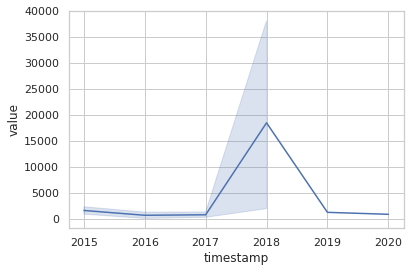

In [32]:
import seaborn as sns
sns.set_theme(style='whitegrid')
sns.lineplot(x = delhi_data['timestamp'].dt.year, y = delhi_data[delhi_data['pollutant'] == 'co']['value'])

Is it just me or is that an outlier in the Dataset ?

<AxesSubplot:xlabel='timestamp', ylabel='value'>

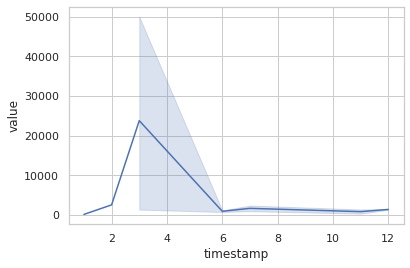

In [33]:
sns.lineplot(x = delhi_data['timestamp'].dt.month, y = delhi_data[delhi_data['pollutant'] == 'co']['value'])

In [34]:
year_2018 = delhi_data[delhi_data['timestamp'].dt.year == 2018]
co_values = year_2018[year_2018['pollutant'] == 'co']
co_values

,location,pollutant,value,timestamp,source_name,averaged_over_in_hours
49,"IHBAS, Delhi - CPCB",co,2500.0,2018-02-22 02:45:00+00:00,CPCB,0.25
55,"ITO, New Delhi - CPCB",co,1440.0,2018-12-15 16:15:00+00:00,caaqm,0.25
61,"Anand Vihar, New Delhi - DPCC",co,20000.0,2018-03-16 23:30:00+00:00,data.gov.in,1.00
67,"Punjabi Bagh, New Delhi - DPCC",co,50000.0,2018-03-20 06:30:00+00:00,data.gov.in,1.00


# No2

<AxesSubplot:xlabel='timestamp', ylabel='value'>

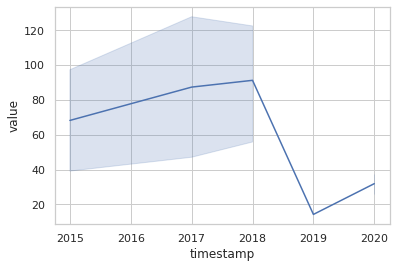

In [35]:
sns.lineplot(x = delhi_data['timestamp'].dt.year, y = delhi_data[delhi_data['pollutant'] == 'no2']['value'])

<AxesSubplot:xlabel='timestamp', ylabel='value'>

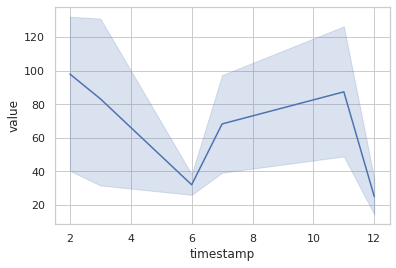

In [36]:
sns.lineplot(x = delhi_data['timestamp'].dt.month, y = delhi_data[delhi_data['pollutant'] == 'no2']['value'])

In [37]:
delhi_data['pollutant'].unique()

array(['co', 'no2', 'o3', 'pm10', 'pm25', 'so2'], dtype=object)

# o3

<AxesSubplot:xlabel='timestamp', ylabel='value'>

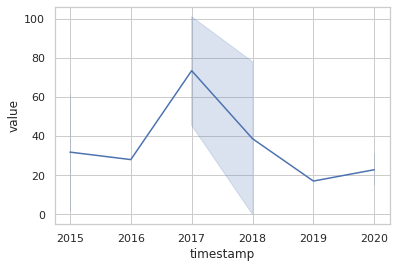

In [38]:
sns.lineplot(x = delhi_data['timestamp'].dt.year, y = delhi_data[delhi_data['pollutant'] == 'o3']['value'])

<AxesSubplot:xlabel='timestamp', ylabel='value'>

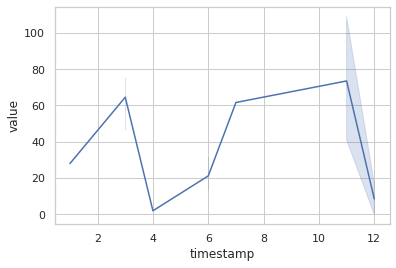

In [39]:
sns.lineplot(x = delhi_data['timestamp'].dt.month, y = delhi_data[delhi_data['pollutant'] == 'o3']['value'])

# pm10

<AxesSubplot:xlabel='timestamp', ylabel='value'>

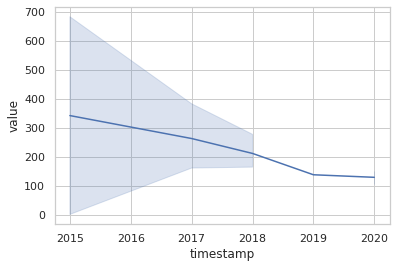

In [40]:
sns.lineplot(x = delhi_data['timestamp'].dt.year, y = delhi_data[delhi_data['pollutant'] == 'pm10']['value'])

<AxesSubplot:xlabel='timestamp', ylabel='value'>

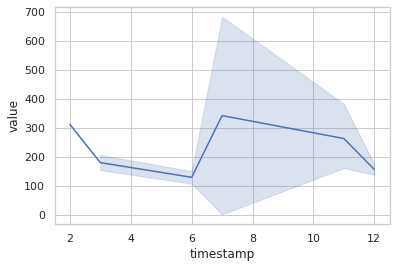

In [41]:
sns.lineplot(x = delhi_data['timestamp'].dt.month, y = delhi_data[delhi_data['pollutant'] == 'pm10']['value'])

# pm25

<AxesSubplot:xlabel='timestamp', ylabel='value'>

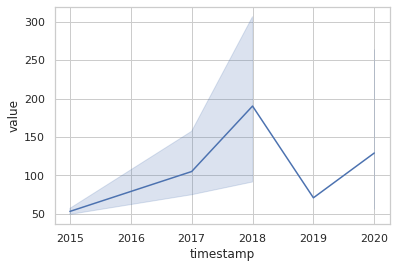

In [42]:
sns.lineplot(x = delhi_data['timestamp'].dt.year, y = delhi_data[delhi_data['pollutant'] == 'pm25']['value'])

<AxesSubplot:xlabel='timestamp', ylabel='value'>

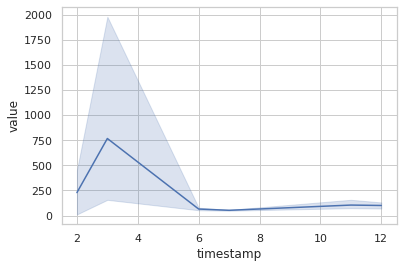

In [43]:
sns.lineplot(x = delhi_data['timestamp'].dt.month, y = delhi_data[delhi_data['pollutant'] == 'pm25']['value'])

# so2 

<AxesSubplot:xlabel='timestamp', ylabel='value'>

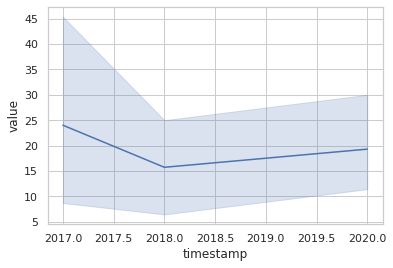

In [44]:
sns.lineplot(x = delhi_data['timestamp'].dt.year, y = delhi_data[delhi_data['pollutant'] == 'so2']['value'])

<AxesSubplot:xlabel='timestamp', ylabel='value'>

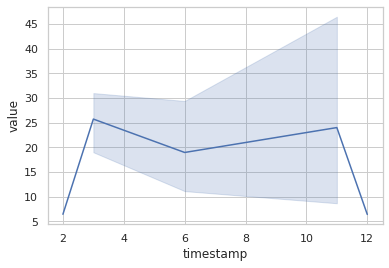

In [45]:
sns.lineplot(x = delhi_data['timestamp'].dt.month, y = delhi_data[delhi_data['pollutant'] == 'so2']['value'])

# Analysis Conclusion


From the above analyis we can conclude the following
* Carbon Monoxide 
    
   **Year in which it peaked**: 2018
    
    **Months in which CO peaks (as per records for prev 5 yrs)**: Feb to April
    
* Nitrogen Dioxide 

     **Year in which it dropped** : 2018
     
     **Peak Months**: July - November
     
* Ozone Gas

    **Peaked in Year** : 2016 - 2017
    
    **Peak Months** : January - March , June - November
    
* PM 10 
    
    **Peaked in Year** : 2015
    
    **Peak Months** : June - July
    
* PM 25

    **Peaked in Years** : 2018
    
    **Peak Month** : February - April
    
* Sulphur Dioxide

    **Peaked after 2018**
    
    


Liked what I did here ? Do press the upvote button !

Have some doubt or a suggestion ? Leave a comment and I'll get back to you ASAP.